In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime
datetime.datetime.strptime
from pandas import to_datetime
from collections import defaultdict
from scipy.stats.stats import pearsonr


In [3]:
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0) #alternative in case of json source df.to_json('filename.json')
df["Sale"] = df["Sale"].str.replace(",", ".").astype(float)
df["BasketDate"] = pd.to_datetime(df["BasketDate"])

df.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,71053,WHITE METAL LANTERN,6
2,536365,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,84406B,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,84029E,RED WOOLLY HOTTIE WHITE HEART.,6


# DATA SEMANTICS



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


Nel dataset si descrivono le sessioni di acquisto di un certo numero di clienti. Una sessione di acquisto, detta basket (BasketID) e si svolge in una data (BasketDate), e viene effettuata da un cliente (CustomerID) residente in uno stato (CustomerCountry).
Ogni sessione rappresenta una serie di prodotti acquistati da un cliente, e in un record è possibile ritrovare, per il singolo prodotto, l’identificativo (ProdID), la descrizione (ProdDescr), e  la quantità (Qtà). Infine viene riportato il costo unitario del prodotto (Sale).

# DISTRIBUTION OF VARIABLES AND STATISTICS


In [5]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


In [6]:
print("Distinct Values in BasketID: \n", df.BasketID.nunique())
print("Distinct Values in BasketDate:\n", df.BasketDate.nunique())
print("Distinct Values in Sale: \n", df.Sale.nunique())
print("Distinct Values in CustomerID: \n", df.CustomerID.nunique())
print("Distinct Values in CustomerCountry: \n", df.CustomerCountry.nunique())
print("Distinct Values in ProdID: \n", df.ProdID.nunique())
print("Distinct Values in ProdDescr: \n", df.ProdDescr.nunique())

Distinct Values in BasketID: 
 24627
Distinct Values in BasketDate:
 22428
Distinct Values in Sale: 
 1146
Distinct Values in CustomerID: 
 4372
Distinct Values in CustomerCountry: 
 38
Distinct Values in ProdID: 
 3953
Distinct Values in ProdDescr: 
 4097


Ore di maggiore traffico

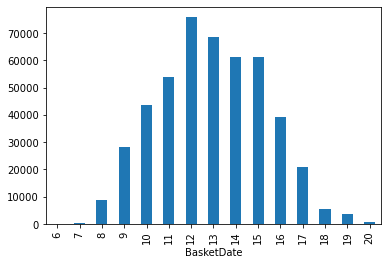

In [7]:
df.groupby(df["BasketDate"].dt.hour)["BasketID"].count().plot(kind="bar")

Date di maggiore traffico nel 2011

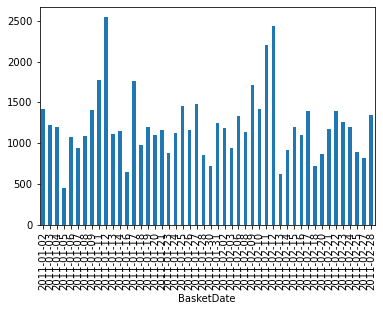

In [8]:
x=df[(df["BasketDate"].dt.year == 2011) & (df["BasketDate"].dt.month <3 )]


x.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")

Date di maggiore traffico nel 2010

20


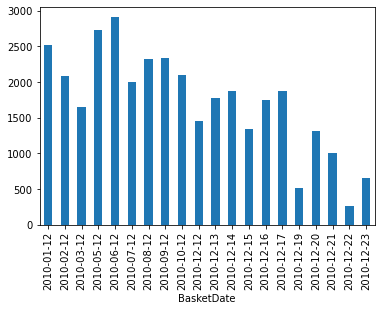

In [9]:
x=df[df["BasketDate"].dt.year == 2010]
print(x["BasketDate"].dt.date.nunique())
x.groupby(df["BasketDate"].dt.date)["BasketID"].count().plot(kind="bar")


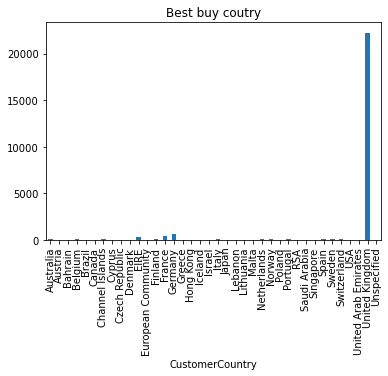

In [10]:
#paesi in cui sono stati effettuati piu acquisti
df.groupby('CustomerCountry')["BasketID"].nunique().plot(kind='bar',

title='Best buy coutry')

In [11]:
#verificare a cosa è dovuta la variazione di prezzo
df.groupby(["ProdID",'Qta'])["Sale"].unique()

ProdID        Qta
10002         -3                  [0.0]
               1     [0.85, 1.66, 1.63]
               2     [1.66, 0.85, 1.63]
               3                 [0.85]
               4                 [0.85]
                            ...        
gift_0001_30   1          [25.53, 25.0]
               30                 [0.0]
gift_0001_40   1         [34.04, 33.33]
gift_0001_50   1                [41.67]
m              1                 [2.55]
Name: Sale, Length: 42152, dtype: object

Distribuzione delle quantità

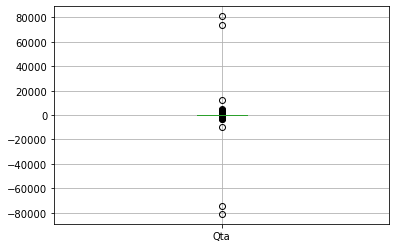

In [10]:
boxplot = df.boxplot(column=['Qta'])

Boxplot raggruppato per paese

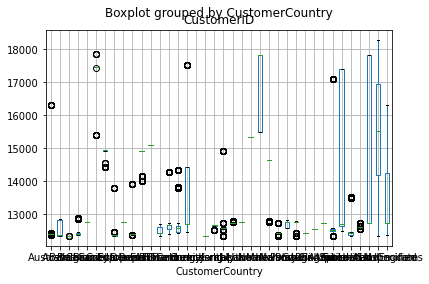

In [11]:
df.boxplot(column=["CustomerID"], by="CustomerCountry")

In [ ]:


#ASSESSING DATA QUALITY (MISSING VALUES, OUTLIERS)



In [ ]:


#VARIABLES TRANSFORMATION & GENERATION



In [ ]:


#PAIRWISE CORRELATION & ELIMINATION OF REDUNTANT VARIABLES